In [1]:
import numpy as np
from generators import generate_databases
from mechanisms import *
from estimator import *
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
tasks = {noisy_max_v1a: {},
         noisy_max_v1b: {},
         noisy_max_v2a: {},
         noisy_max_v2b: {},
         histogram: {},
         histogram_eps: {},
         SVT: {'T': 0.5, 'N': 1},
         iSVT1: {'T': 1},
         iSVT2: {'T': 1},
         iSVT3: {'T': 1, 'N': 1},
         truncated_geometric: {'delta':0.7}}

algorithm = noisy_max_v1a
test_estimator = "opt" # "opt" or "mle"


kwargs = tasks[algorithm]
kwargs['epsilon'] = 0.3


epsilon_list =  np.linspace(0,1,11)

num_input = (5,10)


input_list = []

num_input = (int(num_input), ) if isinstance(num_input, (int, float)) else num_input
for num in num_input:
    input_list.extend(generate_databases(algorithm, num, default_kwargs=kwargs))


In [3]:
def test_results(algorithm, input_list, epsilon_list, n_mean=1000000 ):
    
    delta_list12 = np.zeros([len(input_list), len(epsilon_list)])
    delta_list21 = np.zeros([len(input_list), len(epsilon_list)])

    for i in tqdm(range(len(input_list))):
        (d1,d2, kwargs) = input_list[i]
        np.random.seed()

        n1 = np.random.poisson(n_mean)
        n2 = np.random.poisson(n_mean)
        n12 = np.random.poisson(n_mean)
        n22 = np.random.poisson(n_mean)
        if algorithm in (noisy_max_v1a, noisy_max_v2a,laplace_mechanism,truncated_geometric):
            result_d1 = []
            result_d2 = []
            result_d12 = []
            result_d22 = []
            for _ in range(n1):
                result_d1.append(algorithm(d1, **kwargs))
            for _ in range(n2):
                result_d2.append(algorithm(d2, **kwargs))
            for _ in range(n12):
                result_d12.append(algorithm(d1, **kwargs))
            for _ in range(n22):
                result_d22.append(algorithm(d2, **kwargs))


            count_d1 = dict(zip(*np.unique(result_d1, return_counts=True)))
            count_d2 = dict(zip(*np.unique(result_d2, return_counts=True)))
            count_d12 = dict(zip(*np.unique(result_d12, return_counts=True)))
            count_d22 = dict(zip(*np.unique(result_d22, return_counts=True)))


        elif algorithm in (noisy_max_v1b, noisy_max_v2b,histogram_eps,histogram):
            result_d1 = []
            result_d2 = []
            result_d12 = []
            result_d22 = []
            for _ in range(n1):
                result_d1.append(algorithm(d1, **kwargs))
            for _ in range(n2):
                result_d2.append(algorithm(d2, **kwargs))
            for _ in range(n12):
                result_d12.append(algorithm(d1, **kwargs))
            for _ in range(n22):
                result_d22.append(algorithm(d2, **kwargs))
            range_max = max(np.max(result_d1), np.max(result_d2), np.max(result_d12), np.max(result_d22))
            range_min = min(np.min(result_d1), np.min(result_d2), np.min(result_d12), np.min(result_d22))
            hist1, bin_edges = np.histogram(result_d1, bins = 100, range = (range_min,range_max))
            hist2, bin_edges = np.histogram(result_d2, bins = 100, range = (range_min,range_max))
            hist12, bin_edges = np.histogram(result_d12, bins=100, range=(range_min, range_max))
            hist22, bin_edges = np.histogram(result_d22, bins=100, range=(range_min, range_max))

            intervals = [(bin_edges[i],bin_edges[i+1]) for i in range(len(bin_edges)-1)]
            count_d1 = dict(zip(intervals,hist1))
            count_d2 = dict(zip(intervals,hist2))
            count_d12 = dict(zip(intervals, hist12))
            count_d22 = dict(zip(intervals, hist22))

        elif algorithm in ( iSVT1, iSVT2):
            result_d1 = []
            result_d2 = []
            result_d12 = []
            result_d22 = []
            for _ in range(n1):
                result_d1.append(tuple(algorithm(d1, **kwargs)))
            for _ in range(n2):
                result_d2.append(tuple(algorithm(d2, **kwargs)))
            for _ in range(n12):
                result_d12.append(tuple(algorithm(d1, **kwargs)))
            for _ in range(n22):
                result_d22.append(tuple(algorithm(d2, **kwargs)))

            value_1, count_1 = np.unique(result_d1, return_counts=True,axis=0)
            count_d1 = dict(zip([tuple(x) for x in value_1], count_1))
            value_2, count_2 = np.unique(result_d2, return_counts=True, axis=0)
            count_d2 = dict(zip([tuple(x) for x in value_2], count_2))
            value_12, count_12 = np.unique(result_d12, return_counts=True, axis=0)
            count_d12 = dict(zip([tuple(x) for x in value_12], count_12))
            value_22, count_22 = np.unique(result_d22, return_counts=True, axis=0)
            count_d22 = dict(zip([tuple(x) for x in value_22], count_22))

        elif algorithm in (SVT,iSVT3):
            result_d1 = []
            result_d2 = []
            result_d12 = []
            result_d22 = []
            for _ in range(n1):
                result_d1.append(tuple(algorithm(d1, **kwargs)))
            for _ in range(n2):
                result_d2.append(tuple(algorithm(d2, **kwargs)))
            for _ in range(n12):
                result_d12.append(tuple(algorithm(d1, **kwargs)))
            for _ in range(n22):
                result_d22.append(tuple(algorithm(d2, **kwargs)))

            count_d1 = dict(zip(*np.unique(result_d1, return_counts=True)))
            count_d2 = dict(zip(*np.unique(result_d2, return_counts=True)))
            count_d12 = dict(zip(*np.unique(result_d12, return_counts=True)))
            count_d22 = dict(zip(*np.unique(result_d22, return_counts=True)))
        else:
            raise ValueError('Unsupported algorithm')



        support = list(set(list(count_d1.keys()) + list(count_d2.keys())+list(count_d12.keys())+list(count_d22.keys()) ))

        for event in support:
            if event not in count_d1.keys():
                count_d1[event] = 0
            if event not in count_d2.keys():
                count_d2[event] = 0
            if event not in count_d12.keys():
                count_d12[event] = 0
            if event not in count_d22.keys():
                count_d22[event] = 0
                
        

        for j in range(len(epsilon_list)):
            
            epsilon = epsilon_list[j]
            if test_estimator == "opt":
                delta12 = opt_estimator(count_d1, count_d2, count_d12, count_d22,n1,n2,n12,n22, n_mean, epsilon,c_1 = 4, c_2 = 0.1, c_3 = 0.9)
                delta21 = opt_estimator(count_d2, count_d1, count_d22, count_d12,n2,n1,n22,n12, n_mean, epsilon,c_1 = 4, c_2 = 0.1, c_3 = 0.9)

            elif test_estimator == "mle":
                delta12 = mle_estimator(count_d1, count_d2, n1,n2, epsilon)
                delta21 = mle_estimator(count_d2, count_d1, n2,n1, epsilon)

            delta_list12[i][j] = delta12
            delta_list21[i][j] = delta21
    return delta_list12,delta_list21


In [4]:
delta_list_list = []
num_runs = 10
for i in range(num_runs):
    delta_list12, delta_list21 = test_results(algorithm = algorithm, input_list = input_list, epsilon_list=epsilon_list, n_mean=100000 )
    delta_list = np.maximum(np.amax(delta_list12, axis = 0), np.amax(delta_list21, axis = 0))
    delta_list_list.append(delta_list)

100%|██████████| 16/16 [00:59<00:00,  3.83s/it]


In [5]:
mean_delta = np.mean(np.array(delta_list_list),axis = 0)
ste_delta = np.std(np.array(delta_list_list),axis = 0)/np.sqrt(num_runs)

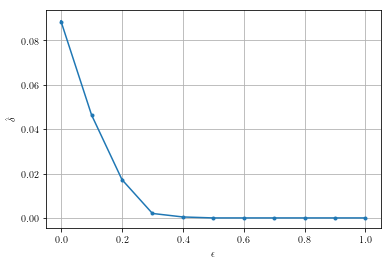

In [6]:

plt.rc('text', usetex=True)
plt.errorbar(epsilon_list, delta_list,ste_delta,marker = ".",label = "region")
plt.xlabel("$\epsilon$")
plt.ylabel("$\hat{\delta}$")
plt.grid()